In [44]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle
import seaborn as sns
from pandas import Timestamp
import gpflow
from gpflow.utilities import print_summary
from gpflow import set_trainable
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [24]:
#Loading saved data
d = pickle.load(open('04-09-2020.p','rb'))
X = d['X']
Y = d['Y']

In [120]:
#Removing one location's data from X
long, lat = 32.5757, 0.322320

In [121]:
#getting the indices of the rows with that locations' data
location_indices = np.where(np.logical_and(X[:,0]==long, X[:,1]==lat))

In [122]:
#creating X dataset
Xset = X[np.logical_not(np.logical_and(X[:,0]==long, X[:,1]==lat))]
Xset.shape

(7495, 3)

In [125]:
location_indices

(array([], dtype=int64),)

In [123]:
#creating Y dataset
Yset = np.delete(Y, slice(location_indices[0][0],location_indices[0][-1]+1), axis=0)
Yset.shape

IndexError: index 0 is out of bounds for axis 0 with size 0

In [33]:
#Removing Nans
keep = ~np.isnan(Yset[:,0])
Yset = Yset[keep,:]
Xset = Xset[keep,:]

In [34]:
#Creating training dataset
Xtraining = Xset[::10,:]
Ytraining = Yset[::10,:]
Xtraining.shape, Ytraining.shape

((734, 3), (734, 1))

In [40]:
#data of deleted location
Xtest = X[np.logical_and(X[:,0]==long, X[:,1]==lat)]
Ytest = Y[location_indices[0][0]:location_indices[0][-1]+1]
Xtest.shape, Ytest.shape

((160, 3), (160, 1))

In [37]:
#defining the kernel
k = gpflow.kernels.RBF(lengthscales=[0.01, 0.01, 1.]) + gpflow.kernels.Bias()
print_summary(k)

╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value            │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0              │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ (3,)    │ float64 │ [0.01 0.01 1.  ] │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0              │
╘═════════════════════════════╧═

In [38]:
#training the model
m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=k, mean_function=None)
set_trainable(m.kernel.kernels[0].lengthscales, False) 
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value            │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0              │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (3,)    │ float64 │ [0.01 0.01 1.  ] │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │

In [39]:
#model optimization
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value             │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 752.252815102796  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (3,)    │ float64 │ [0.01 0.01 1.  ]  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus   

In [41]:
#Making predictions
mean, var = m.predict_f(Xtest)

In [49]:
Ytest

array([[ 31.62      ],
       [ 31.64522727],
       [ 38.4295122 ],
       [ 48.63595238],
       [ 61.58162791],
       [ 61.39930233],
       [ 50.27465116],
       [ 35.59953488],
       [ 38.67813953],
       [ 46.29674419],
       [ 56.83487805],
       [ 46.91465116],
       [ 46.3872093 ],
       [ 40.77261905],
       [ 39.68121951],
       [ 43.28627907],
       [ 41.78659091],
       [ 32.69594595],
       [ 22.67227273],
       [ 21.93431818],
       [ 21.94658537],
       [ 26.12613636],
       [ 19.11954545],
       [ 17.57613636],
       [ 26.0627907 ],
       [ 34.38904762],
       [ 44.47075   ],
       [ 40.55095238],
       [ 39.29119048],
       [ 37.58418605],
       [ 42.03209302],
       [ 46.12488372],
       [ 44.08767442],
       [ 37.30975   ],
       [ 41.48952381],
       [ 34.77214286],
       [ 35.24139535],
       [ 27.84186047],
       [ 37.20232558],
       [ 43.0447619 ],
       [ 30.6725    ],
       [ 19.35512195],
       [ 19.24113636],
       [ 15

In [47]:
mean.numpy()

array([[53.4553211 ],
       [51.71034945],
       [50.399521  ],
       [52.01771006],
       [53.56503748],
       [52.19932288],
       [45.60347119],
       [40.07682352],
       [45.54309759],
       [52.07416517],
       [53.46363181],
       [52.32205306],
       [51.24611429],
       [52.31814242],
       [53.5934949 ],
       [53.90900756],
       [53.89485137],
       [53.62771371],
       [50.87884063],
       [40.29047074],
       [30.97567631],
       [38.00915646],
       [47.08117028],
       [51.37948522],
       [53.43634333],
       [53.92192324],
       [53.9588884 ],
       [53.95675811],
       [53.97049768],
       [53.97645135],
       [53.88337161],
       [53.51532939],
       [53.20243631],
       [53.49919209],
       [53.85431997],
       [53.92895504],
       [53.89344221],
       [53.86046659],
       [53.91173099],
       [53.91847675],
       [53.33982147],
       [50.85636954],
       [45.74995981],
       [35.17755039],
       [27.0104412 ],
       [37

In [50]:
#CalculatiNG RMSE
rmse = sqrt(mean_squared_error(Ytest, mean.numpy()))
rmse

18.095076622579064

In [85]:
f = lambda time: Timestamp.fromtimestamp(time*3600)
f2 = np.vectorize(f)

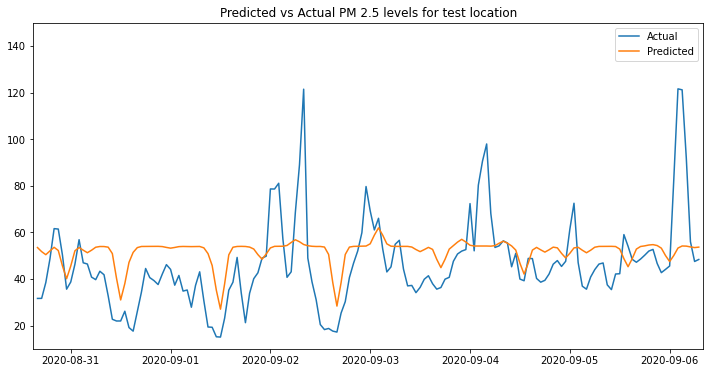

In [114]:
#Plotting results
plt.figure(figsize=(12,6))
plt.title('Predicted vs Actual PM 2.5 levels for test location')
plt.xlim(f2(Xtest[:,2]).min()-timedelta(hours=1), f2(Xtest[:,2]).max()+timedelta(hours=1))
plt.ylim(10,150)
plt.plot(f2(Xtest[:, 2]), Ytest, label='Actual')
plt.plot(f2(Xtest[:, 2]), mean.numpy(), label='Predicted')
plt.legend(loc='best')
plt.show()
plt.savefig('predicted_vs_actual.png')

In [102]:
longs = [X[:,0][index] for index in sorted(np.unique(X[:,0], return_index=True)[1])]
lats = [X[:,1][index] for index in sorted(np.unique(X[:,1], return_index=True)[1])]

0.32232

In [130]:
def cross_validation(long, lat, i):
    location_indices = np.where(np.logical_and(X[:,0]==long, X[:,1]==lat))
    try:
        #Removing location's data from dataset
        Xset = X[np.logical_not(np.logical_and(X[:,0]==long, X[:,1]==lat))]
        Yset = np.delete(Y, slice(location_indices[0][0],location_indices[0][-1]+1), axis=0)
    
        #Removing Nans
        keep = ~np.isnan(Yset[:,0])
        Xset = Xset[keep,:]
        Yset = Yset[keep,:]
    
       #Creating training dataset
        Xtraining = Xset[::10,:]
        Ytraining = Yset[::10,:]
    
        #creating test dataset
        Xtest = X[np.logical_and(X[:,0]==long, X[:,1]==lat)]
        Ytest = Y[location_indices[0][0]:location_indices[0][-1]+1]
    
        #training the model
        m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=k, mean_function=None)
        set_trainable(m.kernel.kernels[0].lengthscales, False) 
    
        #model optimization
        opt = gpflow.optimizers.Scipy()

        def objective_closure():
             return - m.log_marginal_likelihood()

        opt_logs = opt.minimize(objective_closure, m.trainable_variables, options=dict(maxiter=100))
    
        #Making predictions
        mean, var = m.predict_f(Xtest)
    
        #CalculatiNG RMSE and appending to list
        rmse = sqrt(mean_squared_error(Ytest, mean.numpy()))
        rmse_list.append({'latitude':lat, 'longitude':long, 'rmse':rmse})
    
        f = lambda time: Timestamp.fromtimestamp(time*3600)
        f2 = np.vectorize(f)
    
        #Plotting actual vs predicted
        plt.figure(figsize=(12,6))
        plt.title('Location '+str(i))
        plt.xlim(f2(Xtest[:,2]).min()-timedelta(hours=1), f2(Xtest[:,2]).max()+timedelta(hours=1))
        plt.ylim(10,150)
        plt.plot(f2(Xtest[:, 2]), Ytest, label='Actual')
        plt.plot(f2(Xtest[:, 2]), mean.numpy(), label='Predicted')
        plt.legend(loc='best')
        #plt.show()
        plt.savefig('cross_validation/location_'+str(i)+'.png')
    except:
        pass

location  0 done!
location  1 done!
location  2 done!
location  3 done!
location  4 done!
location  5 done!
location  6 done!
location  7 done!
location  8 done!
location  9 done!
location  10 done!
location  11 done!
location  12 done!
location  13 done!
location  14 done!
location  15 done!
location  16 done!
location  17 done!
location  18 done!
location  19 done!
location  20 done!
location  21 done!
location  22 done!
location  23 done!
location  24 done!
location  25 done!
location  26 done!
location  27 done!
location  28 done!
location  29 done!
location  30 done!
location  31 done!
location  32 done!
location  33 done!
location  34 done!
location  35 done!
location  36 done!
location  37 done!
location  38 done!
location  39 done!
location  40 done!
location  41 done!
location  42 done!
location  43 done!
location  44 done!
location  45 done!
location  46 done!
location  47 done!
location  48 done!
location  49 done!
location  50 done!
location  51 done!
location  52 done!
loc

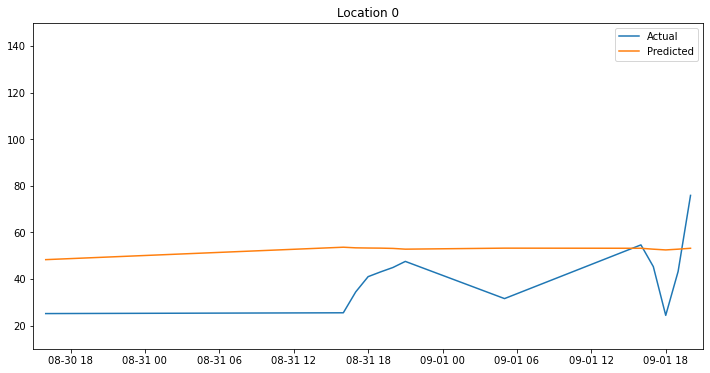

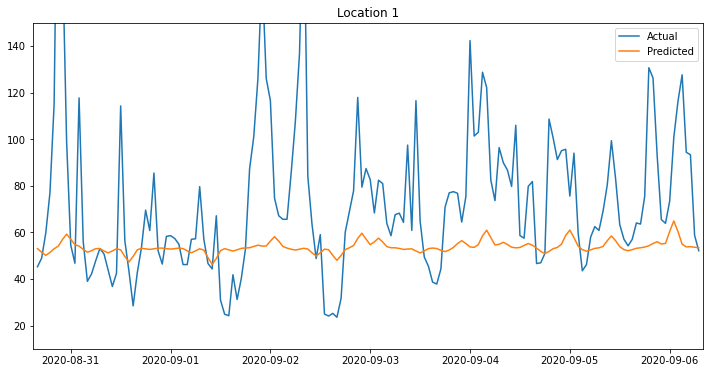

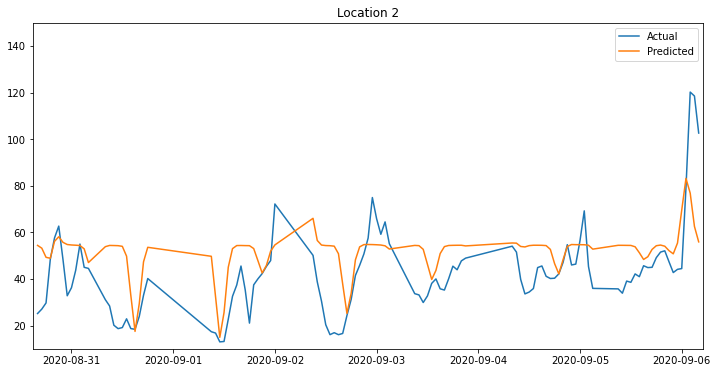

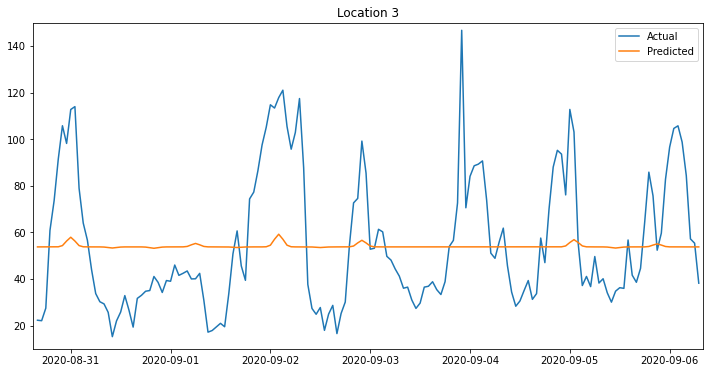

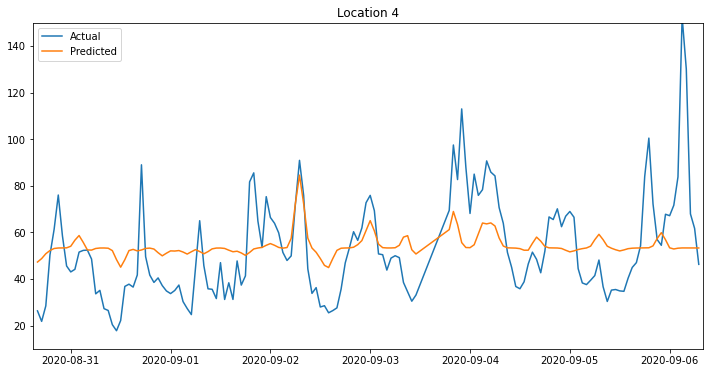

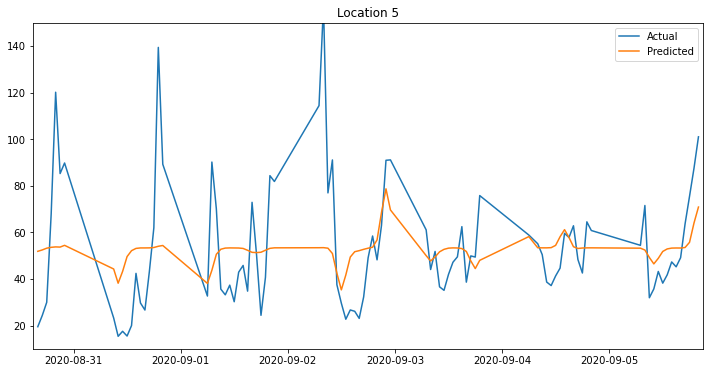

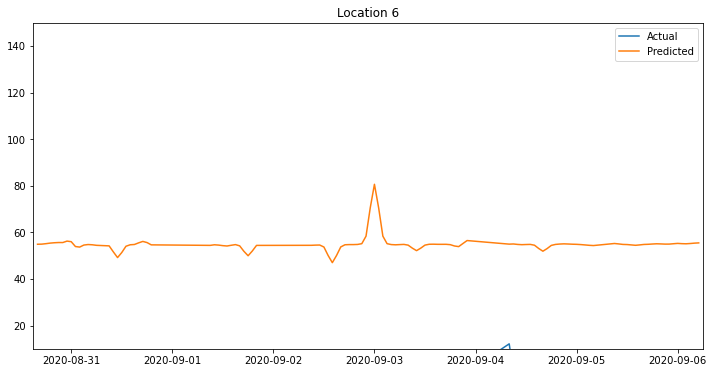

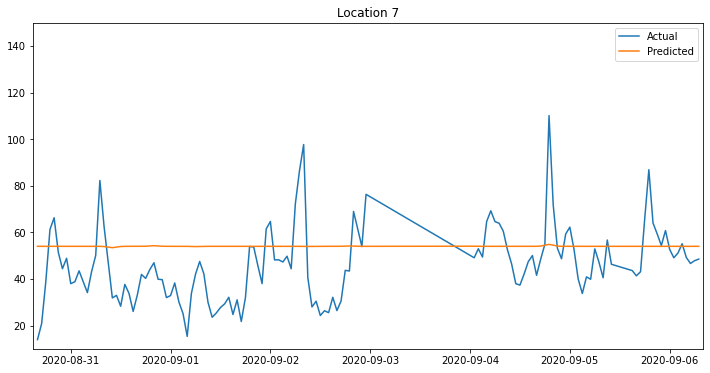

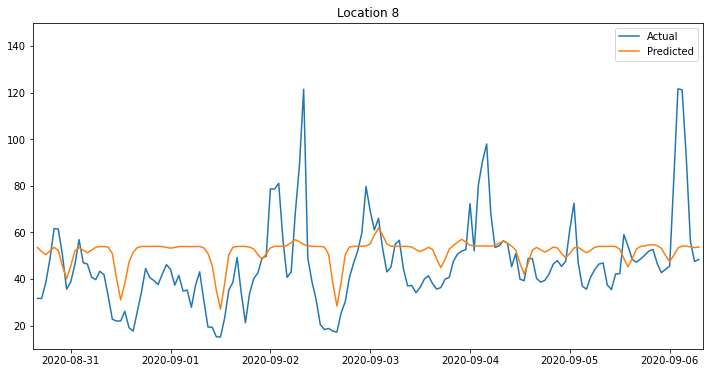

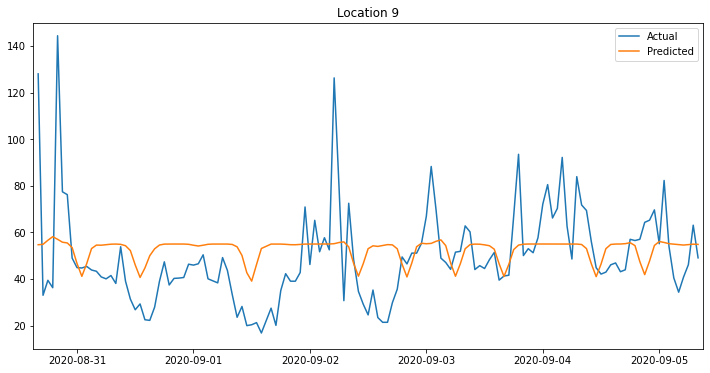

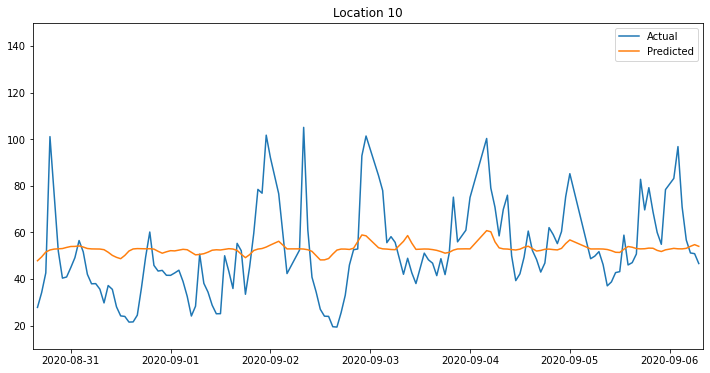

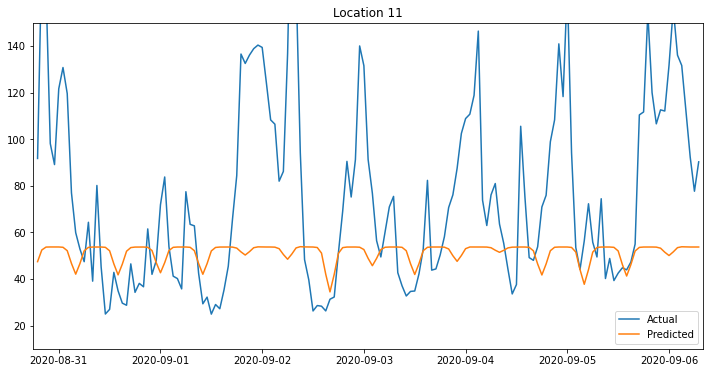

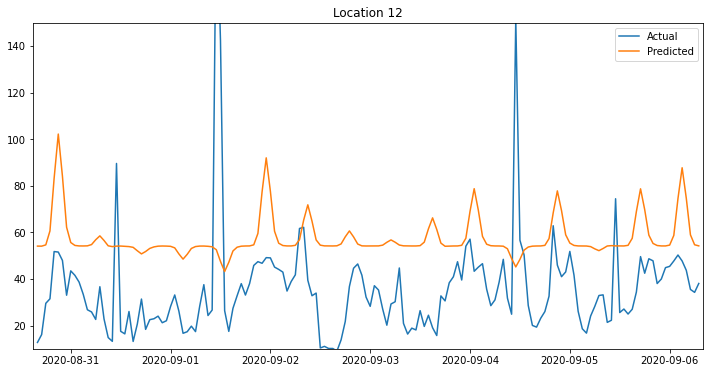

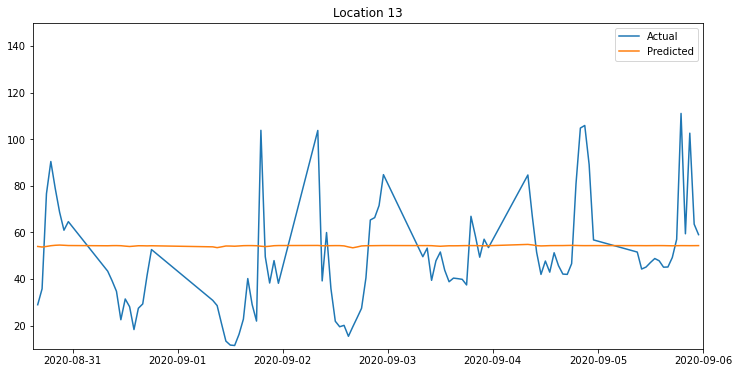

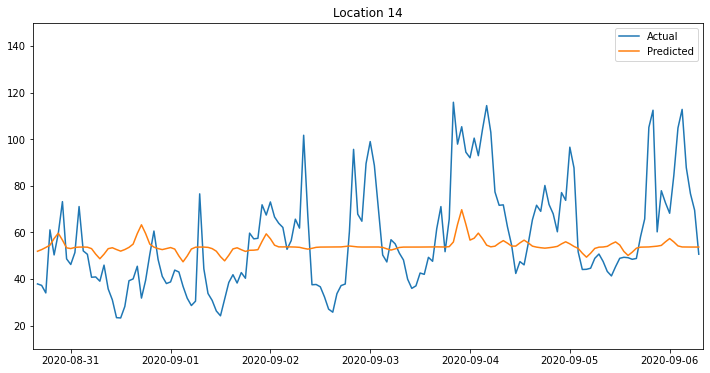

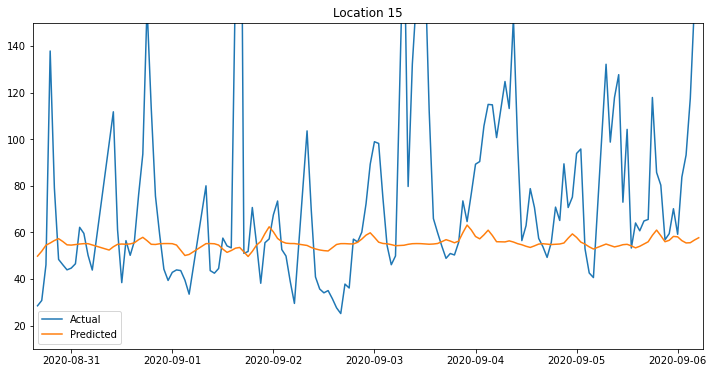

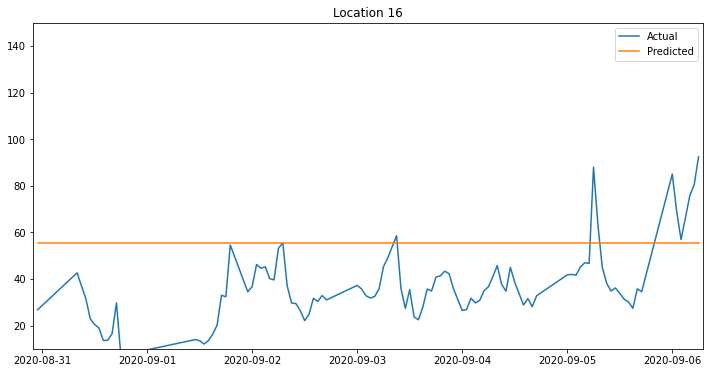

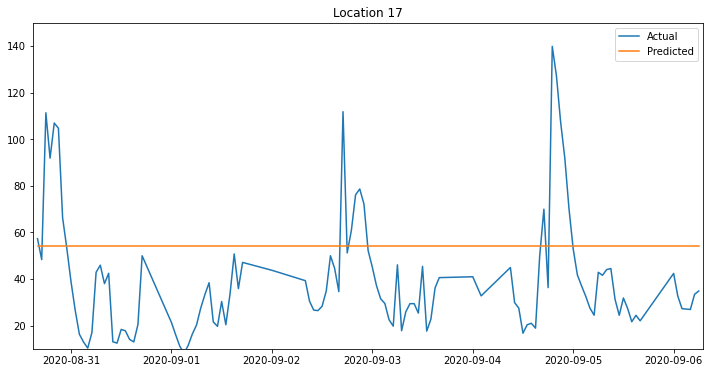

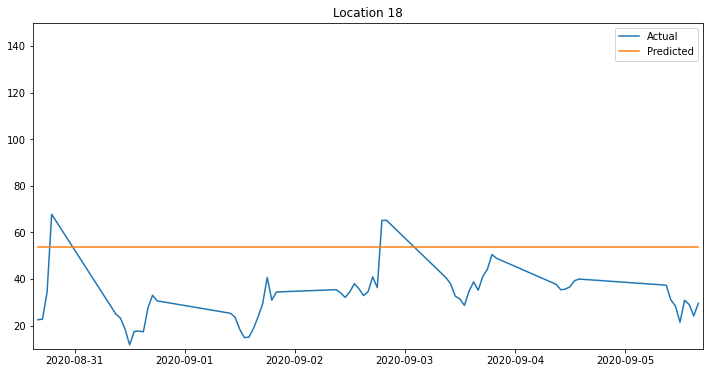

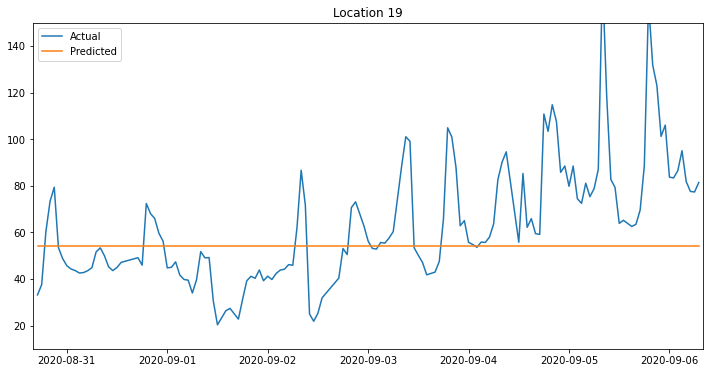

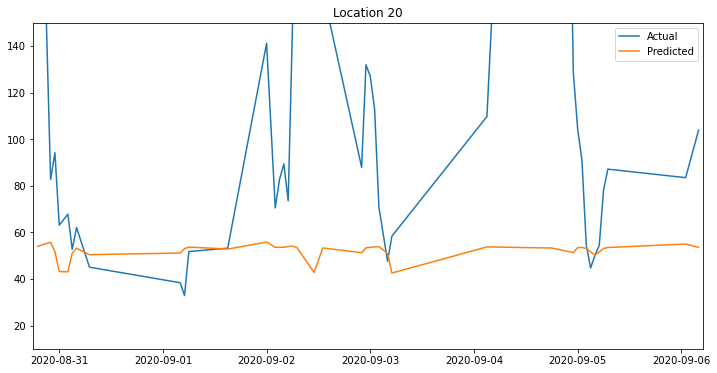

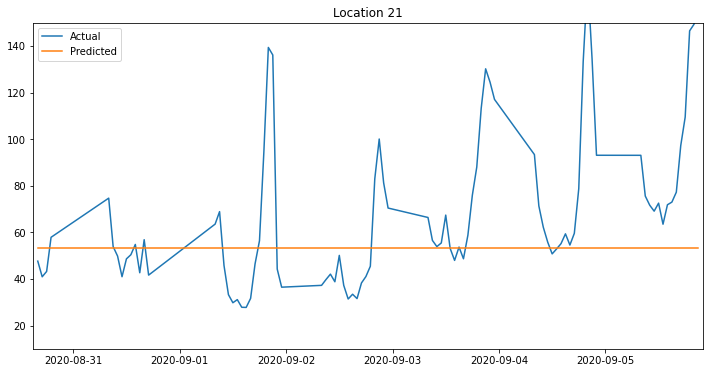

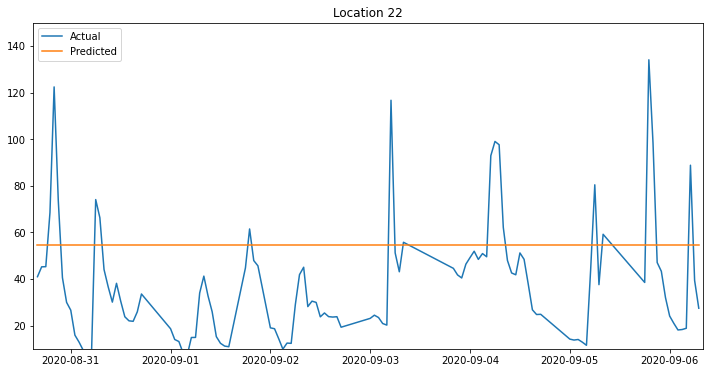

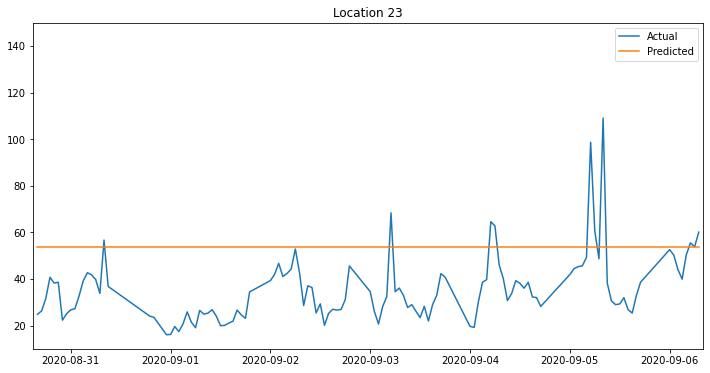

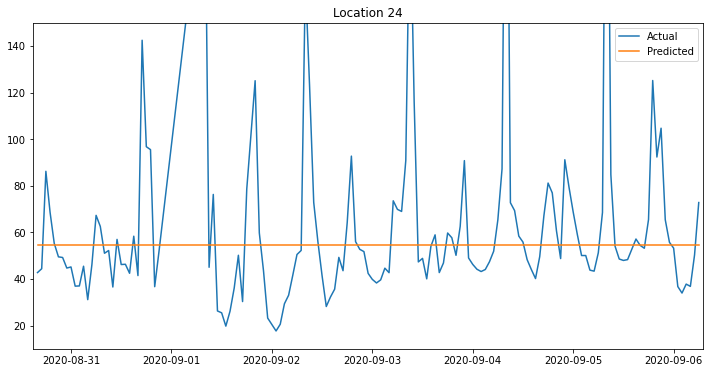

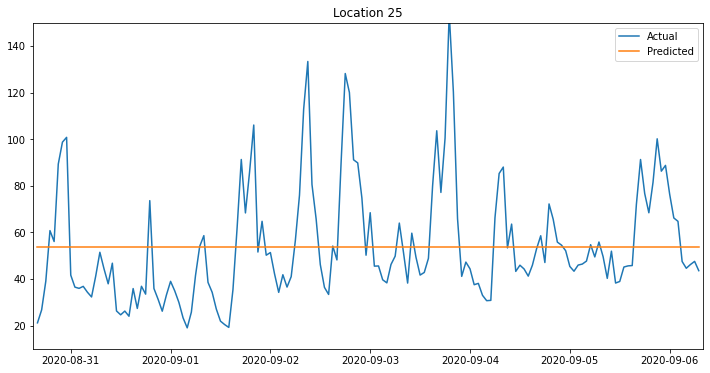

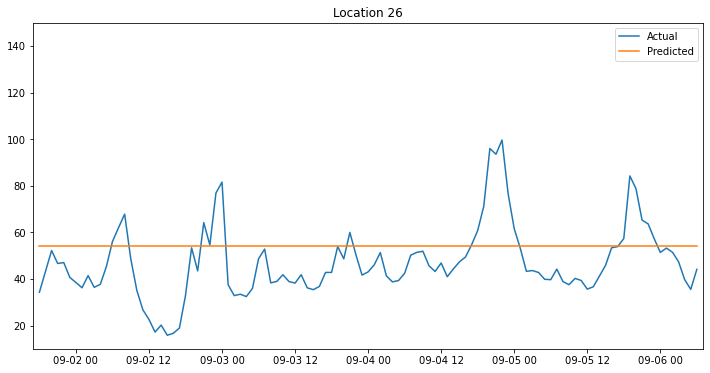

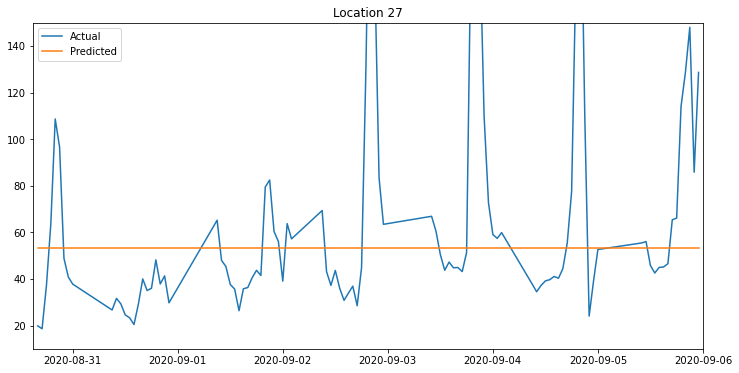

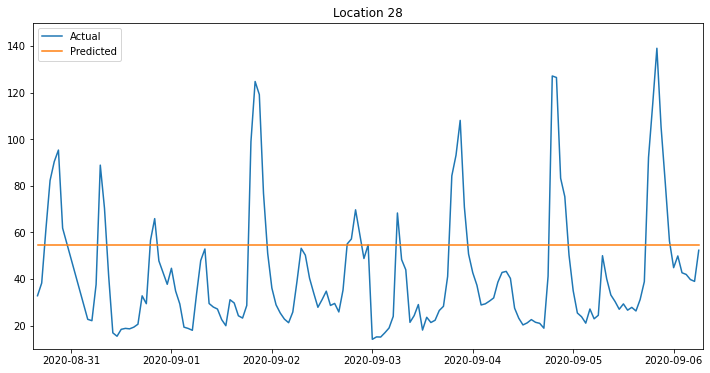

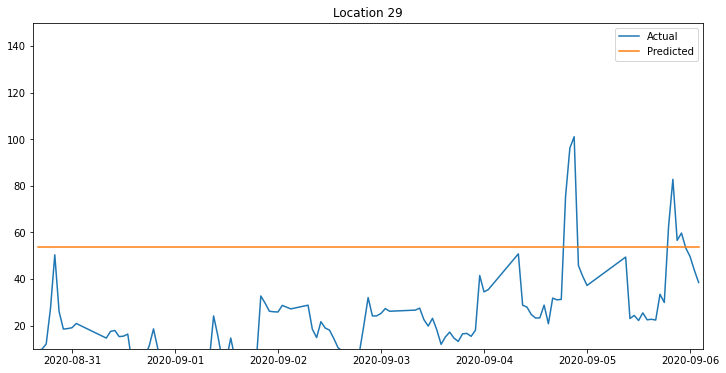

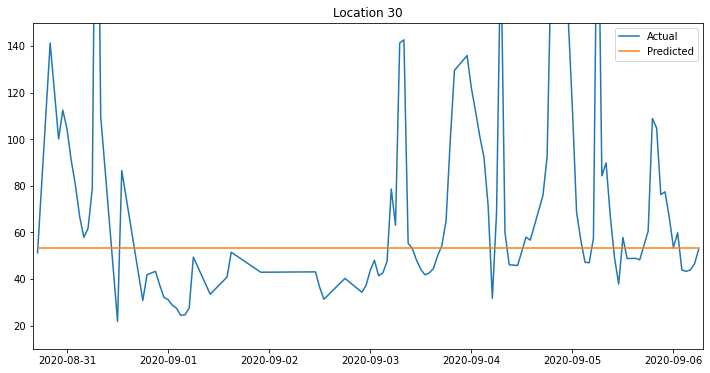

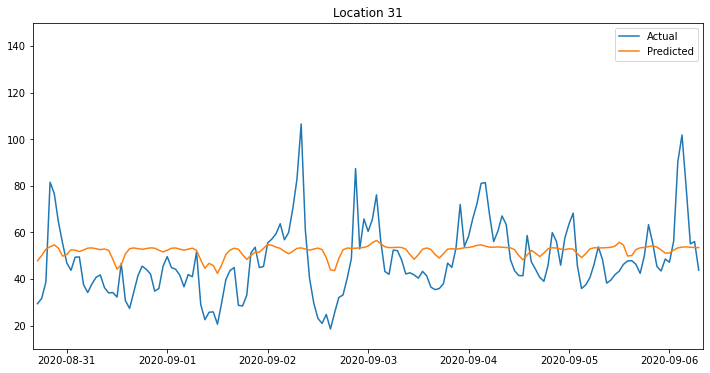

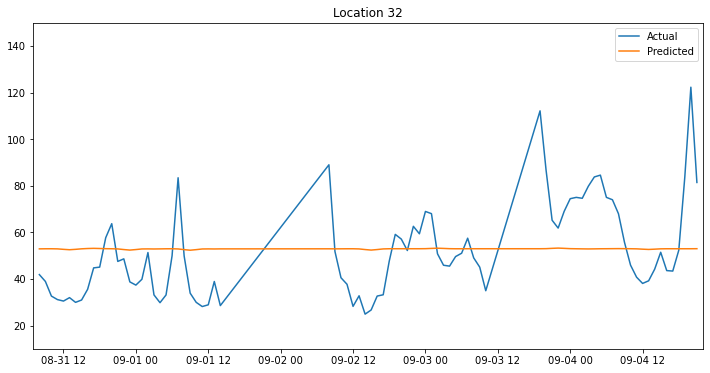

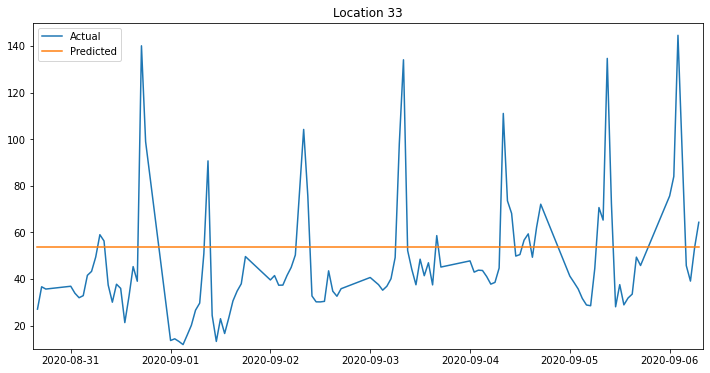

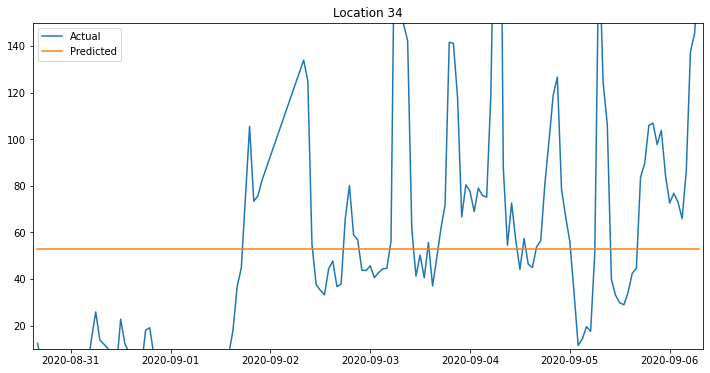

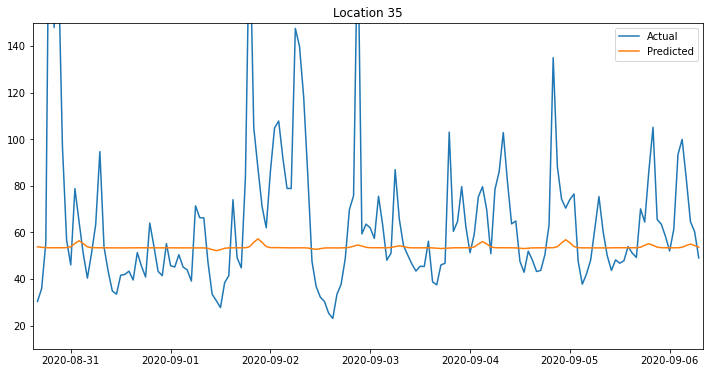

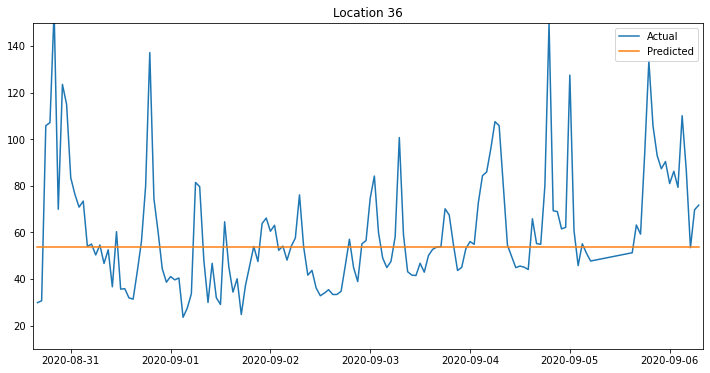

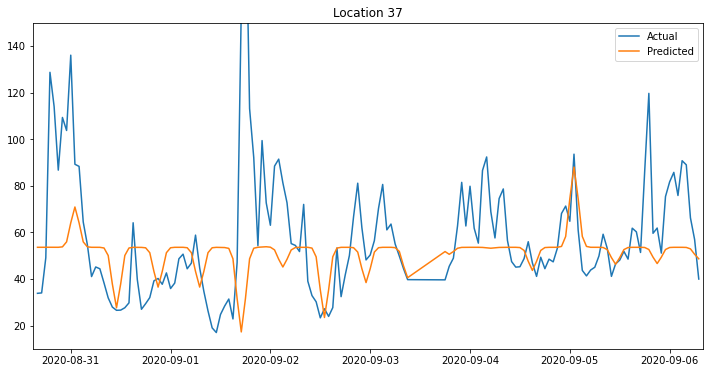

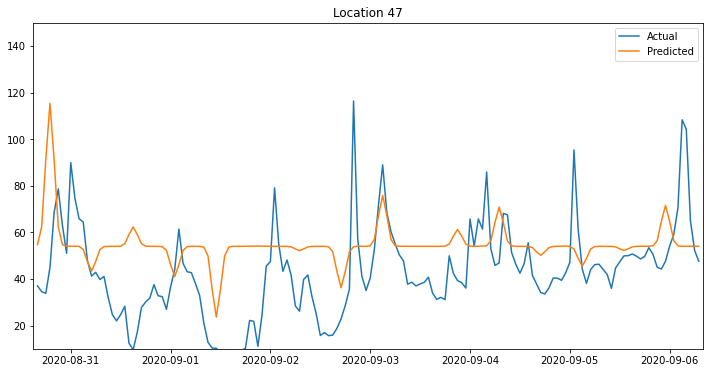

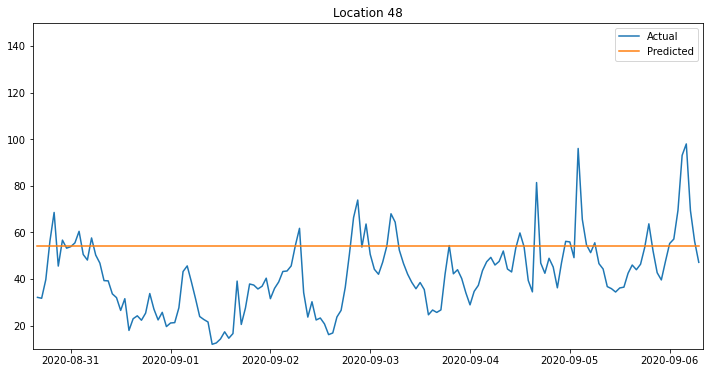

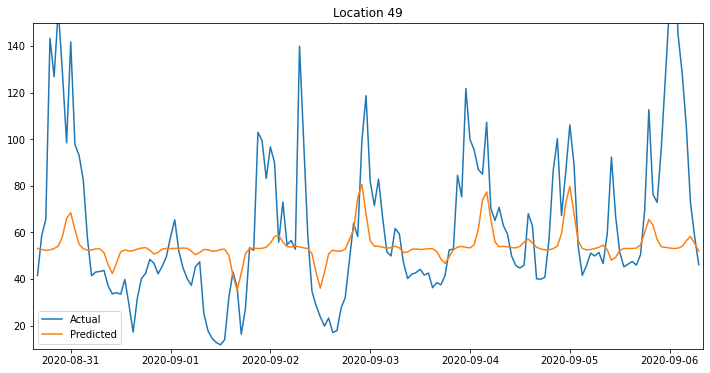

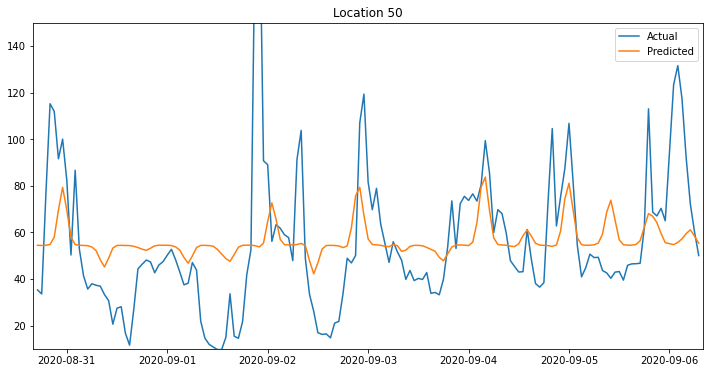

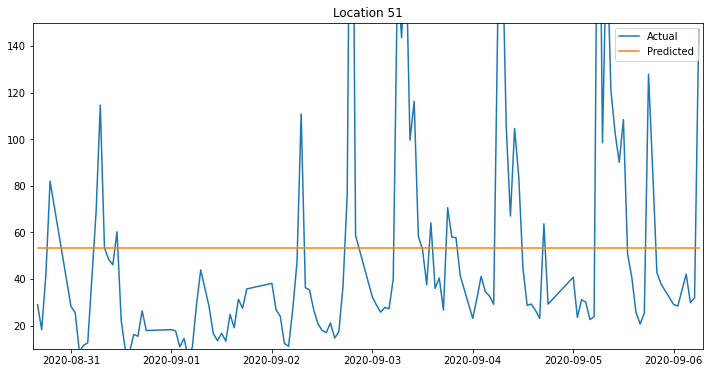

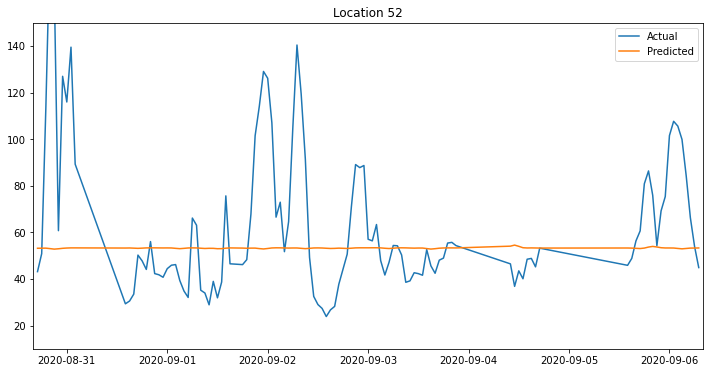

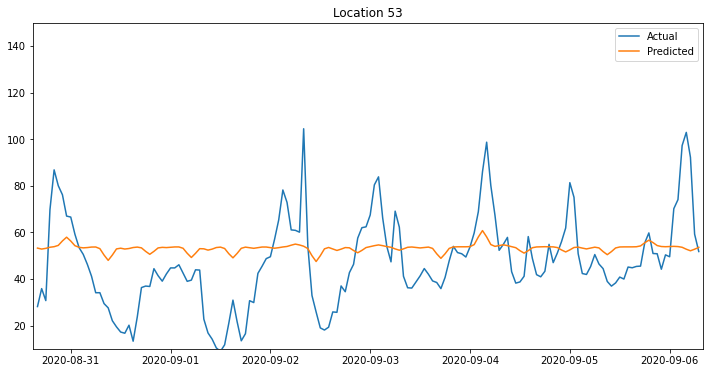

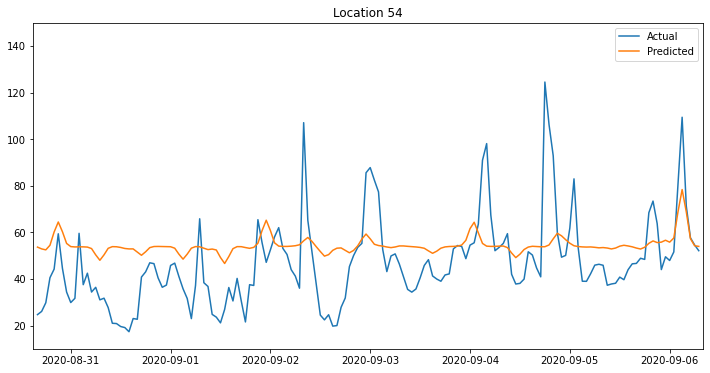

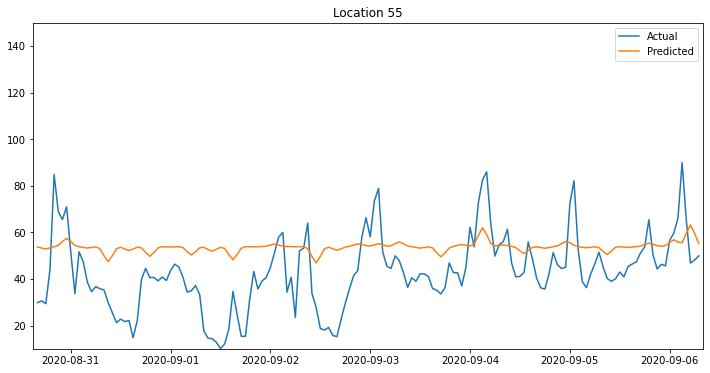

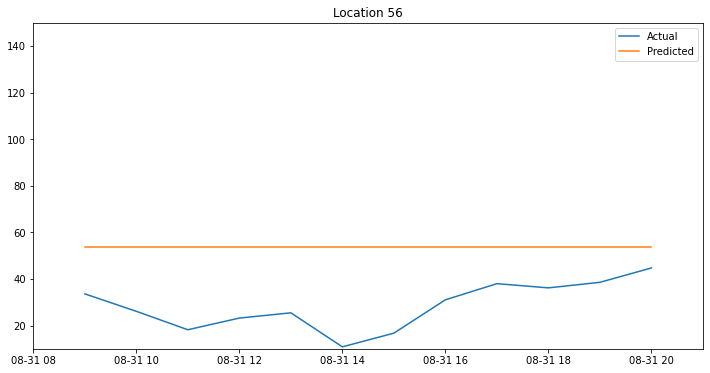

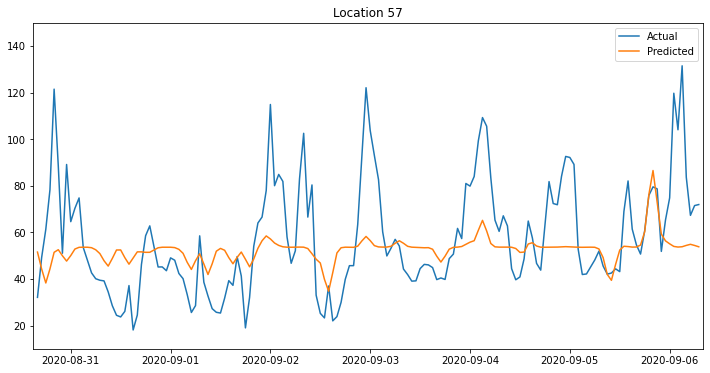

In [131]:
rmse_list = []
for i in range(len(longs)):
    cross_validation(longs[i], lats[i],i)
    print ('location ', i, 'done!')

In [132]:
rmse_list

[{'latitude': 0.391478, 'longitude': 32.62583, 'rmse': 17.44848162447596},
 {'latitude': 0.2689, 'longitude': 32.588, 'rmse': 38.57145806905105},
 {'latitude': 0.322108, 'longitude': 32.576, 'rmse': 18.073801214056083},
 {'latitude': 0.286595, 'longitude': 32.506107, 'rmse': 28.35544541071481},
 {'latitude': 0.3655, 'longitude': 32.6468, 'rmse': 19.923743231519982},
 {'latitude': 0.3577745, 'longitude': 32.5842442, 'rmse': 24.857556937896106},
 {'latitude': 0.341674, 'longitude': 32.635306, 'rmse': 54.90657712223074},
 {'latitude': 0.34646, 'longitude': 32.70328, 'rmse': 17.68700927328346},
 {'latitude': 0.32232, 'longitude': 32.5757, 'rmse': 18.094849064379115},
 {'latitude': 0.325346, 'longitude': 32.632288, 'rmse': 19.909584477444092},
 {'latitude': 0.360209, 'longitude': 32.610756, 'rmse': 18.36715970409559},
 {'latitude': 0.3759, 'longitude': 32.528, 'rmse': 45.70865327345303},
 {'latitude': 0.363, 'longitude': 32.529, 'rmse': 31.81238317018035},
 {'latitude': 0.307, 'longitude': 

In [133]:
#Creating function
mean_rmse = sum(item.get('rmse',0) for item in rmse_list) / len(rmse_list)
mean_rmse

30.56512968313304